For testing 

In [9]:
import torch
from data import *
import params as par
import matplotlib.pyplot as pl
import numpy as np
from scipy import stats as s
import math 
## Load data to plot
r=torch.load('/home/jb739/sheffield/proj/esn2sparse/data/esn_test.pt')
r.shape

torch.Size([10000, 2800])

torch.Size([10000, 28, 28])
tensor([[ 7],
        [ 9],
        [12],
        [16],
        [20]])
(10000, 100, 28)


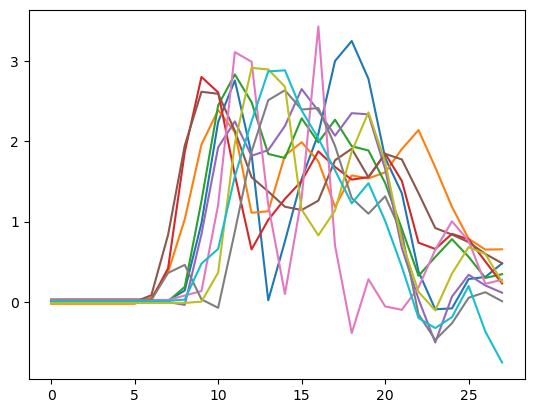

In [10]:
# Extract validation labels
il = seqMNIST(par)
print(f'{il.X_te.shape}')
l = il.label_te
ind = (l==9).nonzero()
print(ind[0:5])
#print(ind)
rr=r.detach().numpy().reshape(10000, 100, 28)
print(rr.shape)
#print(np.max(rr[:]))
fig, ax = pl.subplots()
ax.plot(np.transpose(rr[ind[0:10],0,:].squeeze()))
pl.show()
#ax.plot(np.transpose(s.zscore(rr[ind,0:50], axis=1)))#
#ax.plot(np.transpose(rr[ind,0:50]))

Test the method for extracting anchor, positive and negative samples from input data.

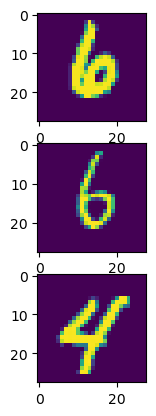

In [84]:
import time
x = il.X_val
label = il.label_val
# Preallocate memory for positive and negative examples
minibatch_size = 20
positive = torch.zeros(minibatch_size, x.shape[1], x.shape[2])
negative = torch.zeros(minibatch_size, x.shape[1], x.shape[2])
# Select anchor samples for this batch
n = 0
N_samp = x.shape[0]
anch_ind = range(n*minibatch_size,min((n+1)*minibatch_size, N_samp))
anchor = torch.clone(x[anch_ind,:])
anch_lab = label[anch_ind]
# Select positive and negative samples for this minibatch
nanch_ind = np.delete(np.arange(0, N_samp), anch_ind) # not anchor indeces
for l in torch.unique(anch_lab):
    indl = anch_lab==l # logical index into anchor
    Nindl = sum(indl)  # no. samples with label l in this batch
    indp = nanch_ind[label[nanch_ind]==l] # index into positive samples
    indn = nanch_ind[label[nanch_ind]!=l] # index into negative samples
    indp = indp[np.random.randint(0, len(indp), Nindl.item())] # Select Nindl indeces for positive samples
    indn = indn[np.random.randint(0, len(indn), Nindl.item())] # Select Nindl indeces for negative samples
    positive[indl,:] = torch.clone(x[indp,:]) # Allocate positive samples
    negative[indl,:] = torch.clone(x[indn,:]) # Allocate negative samples

fig, ax = pl.subplots(3)
j=19
ax[0].imshow(anchor[j,:,:])
ax[1].imshow(positive[j,:,:])
ax[2].imshow(negative[j,:,:])
    


In [11]:
x = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_save.pt')
x.shape

torch.Size([1000, 1000, 101])

In [ ]:
Plot MET responses to the same class over time. Compare responses between classes.

(1000, 101)


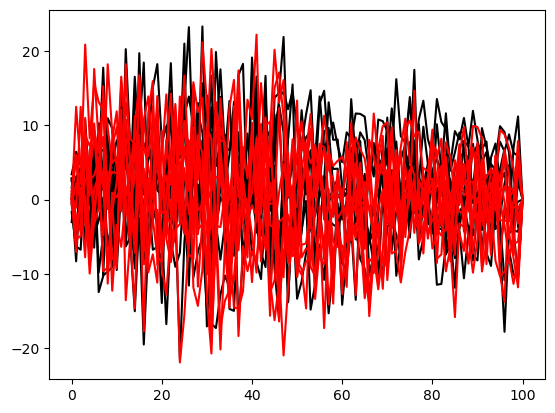

In [12]:

l0 = l==0; l0 = l0[0:1000]
l1 = l==1; l1 = l1[0:1000]
print(x[:,0,:].numpy().shape)
# pl.plot(np.transpose(np.squeeze(np.mean(x[:,0,:].numpy(),0))),'k')
# pl.plot(np.transpose(np.squeeze(np.mean(x[:,1,:].numpy(),0))),'r')
pl.plot(np.transpose(np.squeeze(x[0::100,0,:].numpy())),'k')
pl.plot(np.transpose(np.squeeze(x[0::100,1,:].numpy())),'r')
pl.show()

Check W_esn weight evolution over first training batches.

In [13]:
w = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/wsav.pt')
w.shape

torch.Size([1000, 2800, 101])

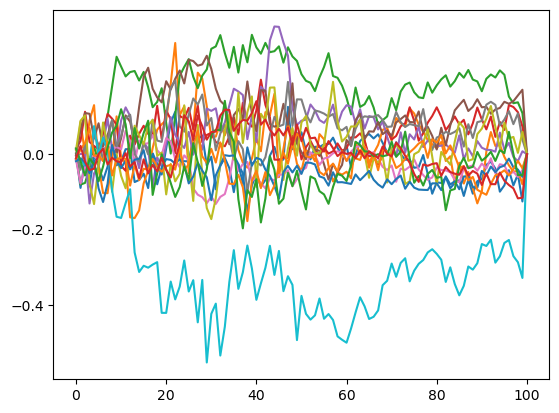

In [14]:
# Weights
pl.plot(np.transpose(torch.squeeze(w[0,0::200,:]).numpy()))
# Absolute rate of change in weights
# pl.plot(np.mean(np.mean(abs(np.diff(torch.squeeze(w[:,0::200,:]).numpy(),axis=2)),1),axis=0))
#pl.imshow(np.squeeze(w[0,:,:]).numpy(),vmin=-0.001,vmax=0.001)
pl.show()

Check for within- and between-classes correlations in ESN responses.

In [51]:
esn = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/esn_test.pt')
print(esn.shape)

torch.Size([10000, 2800])


tensor(892)


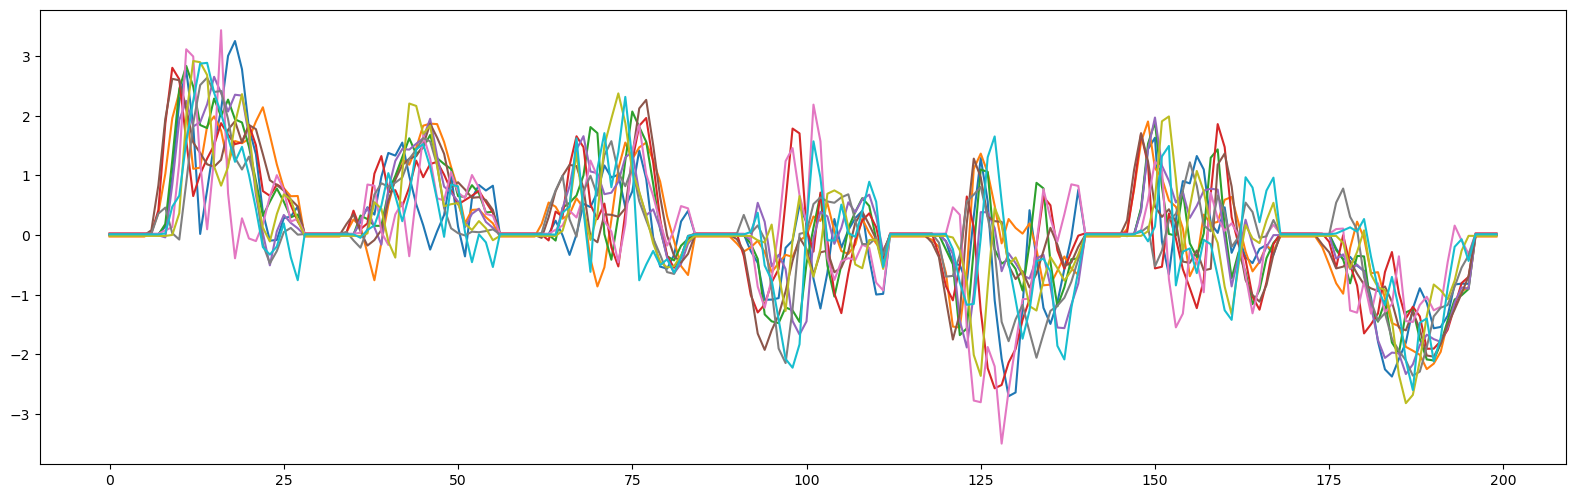

"\nfor k in range(n):\n    print(s.zscore(e1[:,k,:].squeeze().numpy(),1).shape)\n    z1 = s.zscore(e1[:,k,:].squeeze().numpy(),1)\n    z2 = s.zscore(e2[:,k,:].squeeze().numpy(),1)\n    cor[:,:,k] = torch.divide(torch.matmul(torch.tensor(z1), torch.tensor(np.transpose(z2))), 2800.0)\n\nmcor = cor.mean(dim=2)\nprint(mcor.min())\n\n# Class correlations in MET responses\npl.rcParams['svg.fonttype'] = 'none'\nfig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()\nimdata = ax.imshow(mcor,vmin=0.2, vmax=0.6)\ncb = fig.colorbar(imdata, ticks=[0.2, 0.6])\nax.xaxis.set_ticks(np.arange(10)); ax.yaxis.set_ticks(np.arange(10))\nax.tick_params(axis='both', which='major', labelsize=6.0)\ncb.ax.tick_params(labelsize=6.0)\npl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/esn_corr.svg', format='svg')\n"

In [74]:
lab = il.label_te
n = torch.tensor(math.inf)
for j in range(10):
    labj = lab == j
    if torch.sum(labj.long())<n:
        n = torch.sum(labj.long())
print(n)
cor = torch.zeros(10,10,n)
e1 = torch.zeros(10,n,2800)
e2 = torch.zeros(10,n,2800)
for j in range(10):
    ind = (lab==j).nonzero()[0:n].squeeze()
    e1[j,:,:] = esn[ind,:]
    e2[j,:,:] = esn[ind[torch.randperm(n)],:]

ee = e1[9,:,:].reshape(n,100,28)
# fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
# pl.plot(ee[0:10,0,:].transpose(0,1))
fig = pl.figure(figsize=tuple(np.array((50.,15.))/2.54)); ax = pl.axes()
pl.plot(e1[9,0:10,0:200].transpose(0,1))
pl.show()
'''
for k in range(n):
    print(s.zscore(e1[:,k,:].squeeze().numpy(),1).shape)
    z1 = s.zscore(e1[:,k,:].squeeze().numpy(),1)
    z2 = s.zscore(e2[:,k,:].squeeze().numpy(),1)
    cor[:,:,k] = torch.divide(torch.matmul(torch.tensor(z1), torch.tensor(np.transpose(z2))), 2800.0)

mcor = cor.mean(dim=2)
print(mcor.min())

# Class correlations in MET responses
pl.rcParams['svg.fonttype'] = 'none'
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(mcor,vmin=0.2, vmax=0.6)
cb = fig.colorbar(imdata, ticks=[0.2, 0.6])
ax.xaxis.set_ticks(np.arange(10)); ax.yaxis.set_ticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=6.0)
cb.ax.tick_params(labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/esn_corr.svg', format='svg')
'''

Correlation in MET responses

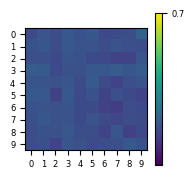

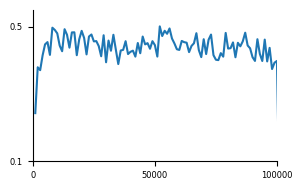

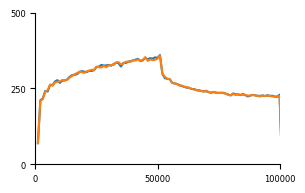

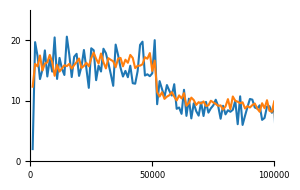

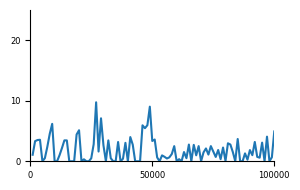

In [19]:
lab = il.label_val[0:1000]
n = torch.tensor(math.inf)
for j in range(10):
    labj = lab == j
    if torch.sum(labj.long())<n:
        n = torch.sum(labj.long())

nt = x.shape[2]
cor = torch.zeros(10,10,n)
xx = torch.zeros(n,10,1000)
mincor = np.zeros(nt,)
for k in range(nt-1):
    for j in range(10):
        ind = ((lab==j).long()*torch.arange(1000))
        if ind[0]==0:
            ind = torch.cat((ind[0:1],ind.nonzero().squeeze()),0)[0:n].squeeze()
        else:
            ind = ind.nonzero()[0:n].squeeze()
            
        xx[:,j,:] = torch.transpose(x[:,ind,k],0,1)
    axx = xx[torch.randperm(n),:,:]
    for j in range(n):   
        if xx[j,:,:].max()==0:
            print(f'....{[k,j]}')
        zxx1 = s.zscore(xx[j,:,:].squeeze().numpy(),1)
        zxx2 = s.zscore(axx[j,:,:].squeeze().numpy(),1)
        if np.isnan(zxx1[:]).any() or np.isnan(zxx2[:]).any():
            print(f'*** {j}')
        cor[:,:,j] = torch.divide(torch.matmul(torch.tensor(zxx1),torch.tensor(np.transpose(zxx2))),1000.0)
    mcor = cor.mean(dim=2)
    weights = np.ones((10,10)) - np.diag(np.zeros(10))
    mincor[k] = np.average(mcor, weights=weights)

# Class correlations in MET responses
pl.rcParams['svg.fonttype'] = 'none'
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(mcor,vmin=0.3, vmax=0.7)
cb = fig.colorbar(imdata, ticks=[0, 0.7])
ax.xaxis.set_ticks(np.arange(10)); ax.yaxis.set_ticks(np.arange(10))
ax.tick_params(axis='both', which='major', labelsize=6.0)
cb.ax.tick_params(labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/corr.svg', format='svg')
# Minimum between-class correlation as a function of training batch
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*1000,mincor)
ax.yaxis.set_ticks((0.1,0.5)); ax.xaxis.set_ticks((0,50000,100000))
ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.1, ymax=0.55)
ax.tick_params(axis='both', which='major', labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/mincor.svg', format="svg")
# Anchor-positive and Anchor-negative distances as function of training batch
d = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_distances.pt')
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*1000,d)
# ax.yaxis.set_ticks((0.0,500,1000,1500)); ax.xaxis.set_ticks((0,50000,100000))
# ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=500.)
ax.yaxis.set_ticks((0.0,250,500)); ax.xaxis.set_ticks((0,50000,100000))
ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=500.)
ax.tick_params(axis='both', which='major', labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/distances.svg', format="svg")
# Training and validation loss as function of training batch
l = torch.load('/home/jb739/sheffield/proj/esn2sparse/data/met_loss.pt')
fig = pl.figure(figsize=tuple(np.array((8.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt,nt)*1000,l)
pl.plot(np.linspace(1,nt,nt)*1000,np.maximum(0, d[:,0].numpy() - d[:,1].numpy() + 1.0))
# ax.yaxis.set_ticks((0,100,50)); ax.xaxis.set_ticks((0,50000,100000))
# ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=100.)
ax.yaxis.set_ticks((0,10,20)); ax.xaxis.set_ticks((0,50000,100000))
ax.set_xlim(xmin=0, xmax=100000); ax.set_ylim(ymin=0.0, ymax=25.)
ax.tick_params(axis='both', which='major', labelsize=6.0)
pl.savefig('/home/jb739/sheffield/proj/esn2sparse/data/losses.svg', format="svg")


Compute distances between anchors and positive/negative samples.

torch.Size([10000, 2800])


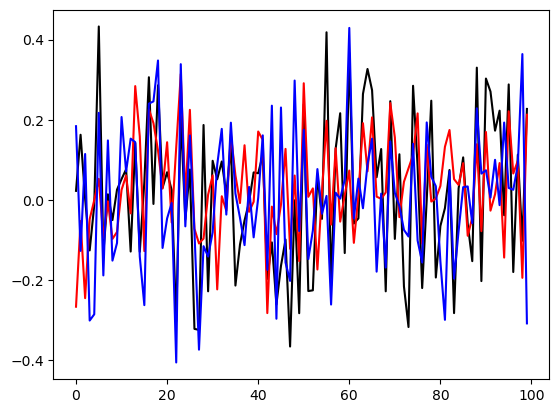

anchor-pos dist = 5.271989822387695    anchor-neg dist = 5.2958784103393555


In [126]:
rr = torch.reshape(r.detach(), (10000, 2800))
print(rr.shape)
label = il.label_val
# Preallocate memory for positive and negative examples
minibatch_size = 20
positive = torch.zeros(minibatch_size, rr.shape[1])
negative = torch.zeros(minibatch_size, rr.shape[1])
# Select anchor samples for this batch
n = 0
N_samp = rr.shape[0]
anch_ind = range(0,minibatch_size)
anchor = torch.clone(rr[anch_ind,:])
anch_lab = label[anch_ind]
# Select positive and negative samples for this minibatch
nanch_ind = np.delete(np.arange(0, N_samp), anch_ind) # not anchor indeces
for l in torch.unique(anch_lab):
    indl = anch_lab==l # logical index into anchor
    Nindl = sum(indl)  # no. samples with label l in this batch
    indp = nanch_ind[label[nanch_ind]==l] # index into positive samples
    indn = nanch_ind[label[nanch_ind]!=l] # index into negative samples
    indp = indp[np.random.randint(0, len(indp), Nindl.item())] # Select Nindl indeces for positive samples
    indn = indn[np.random.randint(0, len(indn), Nindl.item())] # Select Nindl indeces for negative samples
    positive[indl,:] = torch.clone(rr[indp,:]) # Allocate positive samples
    negative[indl,:] = torch.clone(rr[indn,:]) # Allocate negative samples

from models import *
met = METlin(par.N_esn, par.N_met, il.X_tr.shape[2], par.eta_met, par.METsave, par.N_val, par.N_check, par.N_batch)

meta = met.W_esn(anchor).detach()
metp = met.W_esn(positive).detach()
metn = met.W_esn(negative).detach()

j = 1
pl.plot(meta[j,0:100],'k'); pl.plot(metp[j,0:100],'r'); pl.plot(metn[j,0:100],'b')
pl.show()



# Compute distances
# Compute Euclidean distances for debugging
with torch.no_grad():
    d1 = 0.0
    d2 = 0.0
    n_samp = meta.shape[0]
    for j in torch.arange(n_samp):
        d1 += torch.dist(meta[j,:],metp[j,:],2)
        d2 += torch.dist(meta[j,:],metn[j,:],2)

    d1 = d1 / n_samp
    d2 = d2 / n_samp
    
    print(f'anchor-pos dist = {d1}    anchor-neg dist = {d2}')